In [182]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [183]:
# ===========================================
# Setup
# ===========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [184]:
T = 100      # sequence length
tau = 10     # lag
d_model = 64
n_heads = 2
batch_size = 128

In [185]:
n_beh , n_neu = 1, 2

In [186]:
import torch

def generate_batch(batch_size, T, tau, seg_len=25, obs_noise=0.0):
    """
    Generate behavioral (beh) and neural (neu) pairs with alternating
    causal/acausal relationships, using continuous time context.

    - beh: random Gaussian signal, shape [B, T, 1]
    - neu: two channels, shape [B, T, 2]
        ch0 = causal (behavior leads neural) on even segments
        ch1 = acausal (neural leads behavior) on even segments
        Roles swap on odd segments.
    - Shifts are taken from the *full sequence* (no wraparound or zero padding).
    """
    beh = torch.randn(batch_size, T)
    neu = torch.zeros(batch_size, T, n_neu)

    for i in range(batch_size):
        num_segments = T // seg_len

        # Continuous shifted versions of the full behavior trace
        beh_forward  = torch.roll(beh[i], shifts=+tau)  # behavior leads neural
        beh_backward = torch.roll(beh[i], shifts=-tau)  # neural leads behavior

        for s in range(num_segments):
            t0, t1 = s * seg_len, (s + 1) * seg_len

            # Slice from global shifted sequences (preserves continuity)
            causal_seg  = beh_forward[t0:t1]
            acausal_seg = beh_backward[t0:t1]

            # Alternate causal/acausal assignment
            if s % 2 == 0:
                neu[i, t0:t1, 0] = causal_seg
                #neu[i, t0:t1, 1] = acausal_seg
                neu[i, t0:t1, 1] = causal_seg
            else:
                neu[i, t0:t1, 0] = acausal_seg
                #neu[i, t0:t1, 1] = causal_seg
                neu[i, t0:t1, 1] = acausal_seg

    # Add small independent observation noise
    neu += obs_noise * torch.randn_like(neu)
    beh = beh.unsqueeze(-1)
    return beh, neu

In [187]:
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)

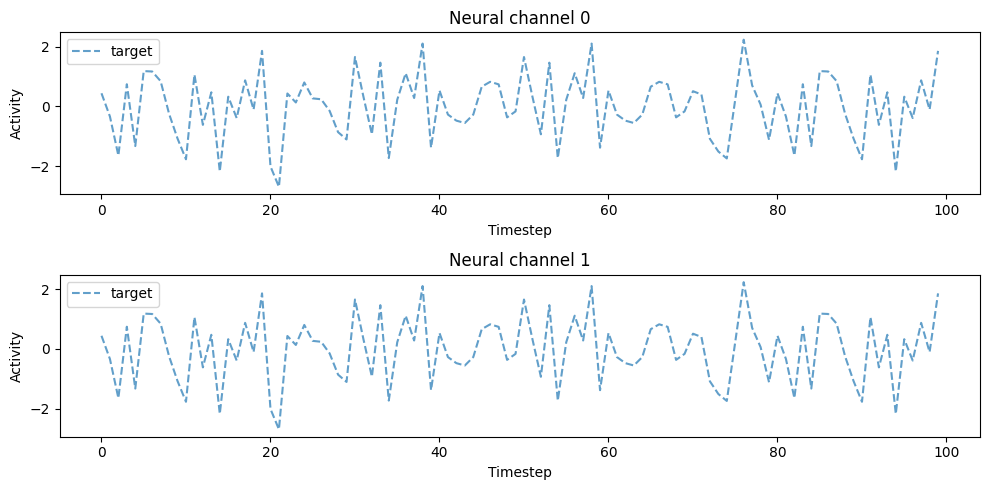

In [188]:
b = 0  # sample index
plt.figure(figsize=(10,5))
for c in range(neu_test.shape[-1]):
    plt.subplot(n_neu,1,c+1)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()

In [189]:
# ===========================================
# Positional Encoding
# ===========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

pos_enc = PositionalEncoding(d_model).to(device)

In [190]:
# ===========================================
# Minimal Cross-Attention Model
# (split into causal and acausal attention modules)
# ===========================================
class BiXLagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert n_heads % 2 == 0, "n_heads must be even for causal/acausal split"

        self.in_proj_beh = nn.Linear(n_beh, d_model)
        self.in_proj_neu = nn.Linear(n_neu, d_model)        
        
        self.n_heads = n_heads
        self.n_causal = n_heads // 2
        self.n_acausal = n_heads // 2

        # Two separate attention modules
        self.attn_causal = nn.MultiheadAttention(d_model, self.n_causal, batch_first=True)
        self.attn_acausal = nn.MultiheadAttention(d_model, self.n_acausal, batch_first=True)

        self.reduce_dim = 1  # or whatever latent dimension you want
        self.attn_out_causal_proj = nn.Linear(d_model, self.reduce_dim)  # reduce from attn_out dim
        self.attn_out_acausal_proj = nn.Linear(d_model, self.reduce_dim)  # reduce from attn_out dim
        self.out_neu_proj = nn.Linear(2*self.reduce_dim, n_neu)  # predict neural channels
        self.out_beh_proj = nn.Linear(2*self.reduce_dim, n_beh)  # predict behavior

    def forward(self, x, y_query):
        # x: encoder input [B, T_enc, 1]
        # y_query: decoder query [B, T_dec, 1]
        x_emb = pos_enc(self.in_proj_beh(x))
        y_emb = pos_enc(self.in_proj_neu(y_query))

        B, T_dec, _ = y_emb.shape
        T_enc = x_emb.shape[1]
        device = y_emb.device

        # ------------------------------------------------
        # Build attention masks
        # ------------------------------------------------
        mask_causal = torch.triu(torch.ones(T_dec, T_enc, device=device), diagonal=1).bool()
        mask_acausal = torch.tril(torch.ones(T_dec, T_enc, device=device), diagonal=-1).bool()

        # ------------------------------------------------
        # Apply both attention modules
        # ------------------------------------------------
        out_causal, w_causal = self.attn_causal(
            y_emb, x_emb, x_emb,
            attn_mask=mask_causal,
            need_weights=True,
            average_attn_weights=False
        )

        out_acausal, w_acausal = self.attn_acausal(
            y_emb, x_emb, x_emb,
            attn_mask=mask_acausal,
            need_weights=True,
            average_attn_weights=False
        )

        attn_weights = torch.cat([w_causal, w_acausal], dim=1)  # concat along head dimension
        # 🔻 Reduce to a lower-dimensional latent subspace
        z_causal = self.attn_out_causal_proj(out_causal)
        z_acausal = self.attn_out_causal_proj(out_acausal)

        # Concatenate outputs and attention weights
        z_out = torch.cat([z_causal, z_acausal], dim=-1)

        out_neu = self.out_neu_proj(z_out)
        out_beh = self.out_beh_proj(z_out)

        return out_neu, out_beh, attn_weights, z_out

In [191]:
# ===========================================
# Minimal Cross-Attention Model
# (split into causal and acausal attention modules)
# ===========================================
class LagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert n_heads % 2 == 0, "n_heads must be even for causal/acausal split"

        self.in_proj_beh = nn.Linear(n_beh, d_model)
        self.in_proj_neu = nn.Linear(n_neu, d_model)        
        
        self.n_heads = n_heads
        self.n_causal = n_heads // 2
        self.n_acausal = n_heads // 2

        # Two separate attention modules
        self.attn_causal = nn.MultiheadAttention(d_model, self.n_causal, batch_first=True)
        self.attn_acausal = nn.MultiheadAttention(d_model, self.n_acausal, batch_first=True)

        self.reduce_dim = 1  # or whatever latent dimension you want
        self.attn_out_causal_proj = nn.Linear(d_model, self.reduce_dim)  # reduce from attn_out dim
        self.attn_out_acausal_proj = nn.Linear(d_model, self.reduce_dim)  # reduce from attn_out dim
        self.out_neu_proj = nn.Linear(2*self.reduce_dim, n_neu)  # predict neural channels
        self.out_beh_proj = nn.Linear(2*self.reduce_dim, n_beh)  # predict behavior

    def forward(self, x, y_query):
        # x: encoder input [B, T_enc, 1]
        # y_query: decoder query [B, T_dec, 1]
        x_emb = pos_enc(self.in_proj_beh(x))
        y_emb = pos_enc(self.in_proj_neu(y_query))

        # ------------------------------------------------
        # Apply both attention modules
        # ------------------------------------------------
        out_causal, w_causal = self.attn_causal(
            y_emb, x_emb, x_emb,
            need_weights=True,
            average_attn_weights=False
        )

        out_acausal, w_acausal = self.attn_acausal(
            y_emb, x_emb, x_emb,
            need_weights=True,
            average_attn_weights=False
        )

        attn_weights = torch.cat([w_causal, w_acausal], dim=1)  # concat along head dimension
        # 🔻 Reduce to a lower-dimensional latent subspace
        z_causal = self.attn_out_causal_proj(out_causal)
        z_acausal = self.attn_out_causal_proj(out_acausal)

        # Concatenate outputs and attention weights
        z_out = torch.cat([z_causal, z_acausal], dim=-1)

        out_neu = self.out_neu_proj(z_out)
        out_beh = self.out_beh_proj(z_out)

        return out_neu, out_beh, attn_weights, z_out

In [192]:
n_steps = 2000

In [215]:
# instantiate / train as usual
model = BiXLagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    beh, neu = generate_batch(batch_size, T, tau)
    beh, neu = beh.to(device), neu.to(device)
    neu_query = torch.zeros_like(neu)  # decoder starts with zeros

    neu_pred, beh_pred, _, _ = model(beh, neu_query)
    #loss = loss_fn(torch.cat((neu_pred, beh_pred), dim=-1),
    #           torch.cat((neu, beh), dim=-1))    
    loss = loss_fn(neu_pred, neu)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

Step 500/2000, Loss: 0.333364
Step 1000/2000, Loss: 0.195440
Step 1500/2000, Loss: 0.166340
Step 2000/2000, Loss: 0.153941


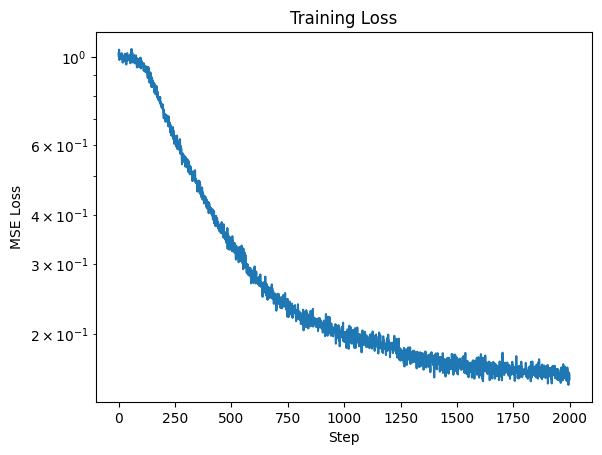

In [216]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [217]:
# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, z_out = model(beh_test, neu_query)

attn_weights.shape

torch.Size([1, 2, 100, 100])

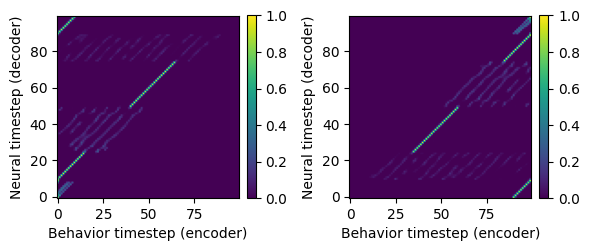

In [218]:
import math
import matplotlib.pyplot as plt

layer_attn = attn_weights[0]  # shape (n_heads, T_dec, T_enc)
n_heads = layer_attn.shape[0]
cols = math.ceil(math.sqrt(n_heads))
rows = math.ceil(n_heads / cols)

# Each subplot 3x3 inches → square layout
plt.figure(figsize=(3 * cols, 3 * rows))
for h in range(n_heads):
    attn_map = layer_attn[h].cpu().numpy()
    ax = plt.subplot(rows, cols, h + 1)
    im = ax.imshow(attn_map, aspect='equal', origin='lower', cmap='viridis')  # <- square cells
    ax.set_xlabel("Behavior timestep (encoder)")
    ax.set_ylabel("Neural timestep (decoder)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("heads_BiX_square.png", dpi=300, bbox_inches='tight')
plt.show()

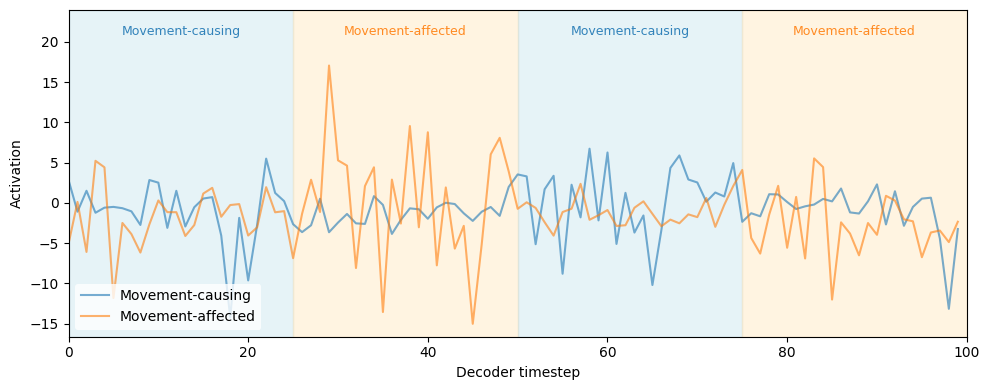

<Figure size 640x480 with 0 Axes>

In [219]:
import matplotlib.pyplot as plt
import torch

seg_len = 25  # match your generator

B, T, D2 = z_out.shape
D = D2 // 2
b = 1
causal_out = z_out[0, :, :D].detach().cpu()
acausal_out = z_out[0, :, D:].detach().cpu()

fig, ax = plt.subplots(figsize=(10, 4))

# --- Shaded background for alternating causal/acausal periods ---
for s in range(0, T, seg_len):
    if (s // seg_len) % 2 == 0:
        ax.axvspan(s, s + seg_len, color='lightblue', alpha=0.3, zorder=0)
    else:
        ax.axvspan(s, s + seg_len, color='moccasin', alpha=0.4, zorder=0)

# --- Plot latent components ---
for d in range(D):
    ax.plot(causal_out[:, d], color='tab:blue', alpha=0.6,
            label='Movement-causing' if d == 0 else "")
for d in range(D):
    ax.plot(acausal_out[:, d], color='tab:orange', alpha=0.6,
            label='Movement-affected' if d == 0 else "")

# --- Labels, limits, etc. ---
ax.set_xlabel("Decoder timestep")
ax.set_ylabel("Activation")
ax.set_xlim(0, T)

# --- Add top text labels for shaded regions ---
ymin, ymax = ax.get_ylim()
label_y = ymax + (ymax - ymin) * 0.05  # place slightly above top of data

for s in range(0, T, seg_len):
    mid = s + seg_len / 2
    if (s // seg_len) % 2 == 0:
        ax.text(mid, label_y, "Movement-causing",
                color='tab:blue', ha='center', va='bottom', fontsize=9, alpha=0.9)
    else:
        ax.text(mid, label_y, "Movement-affected",
                color='tab:orange', ha='center', va='bottom', fontsize=9, alpha=0.9)

# Extend y-limits to make room for the top text
ax.set_ylim(ymin, label_y + (ymax - ymin) * 0.1)

# --- Move legend to bottom-left (away from text) ---
leg = ax.legend(loc='lower left', frameon=True, framealpha=0.8)
leg.get_frame().set_edgecolor('none')

plt.tight_layout()
plt.show()
plt.savefig("latent_components_BiX.png", dpi=300, bbox_inches='tight')

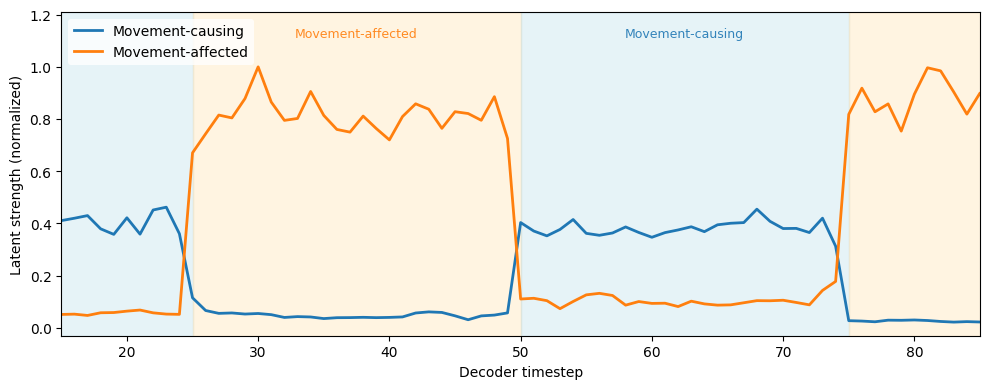

In [220]:
import matplotlib.pyplot as plt
import torch

# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(500, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, z_out = model(beh_test, neu_query)

# --- Compute mean of squares across batch (latent magnitude) ---
z_strength = (z_out ** 2).mean(dim=0).detach().cpu()  # [T, D_total]
T, D2 = z_strength.shape
D = D2 // 2

causal_out = z_strength[:, :D]
acausal_out = z_strength[:, D:]

# --- Average across latent dims to get envelope ---
causal_strength = causal_out.mean(dim=1)
acausal_strength = acausal_out.mean(dim=1)

# --- Normalize by global max across both ---
max_val = torch.max(torch.cat([causal_strength, acausal_strength]))
causal_strength /= max_val
acausal_strength /= max_val

# --- Plot ---
seg_len = 25  # match your generator
fig, ax = plt.subplots(figsize=(10, 4))

# Background shading for causal/acausal periods
for s in range(0, T, seg_len):
    if (s // seg_len) % 2 == 0:
        ax.axvspan(s, s + seg_len, color='lightblue', alpha=0.3, zorder=0)
    else:
        ax.axvspan(s, s + seg_len, color='moccasin', alpha=0.4, zorder=0)

# Plot normalized latent strength envelopes
ax.plot(causal_strength, color='tab:blue', lw=2, label='Movement-causing')
ax.plot(acausal_strength, color='tab:orange', lw=2, label='Movement-affected')

# Labels and limits
ax.set_xlabel("Decoder timestep")
ax.set_ylabel("Latent strength (normalized)")  # <- updated
ax.set_xlim(0, T)

# Optional figure title
#ax.set_title("Causal vs. acausal latent strength", fontsize=11)

# Add top text labels for shaded regions
ymin, ymax = ax.get_ylim()
label_y = ymax + (ymax - ymin) * 0.05

for i, s in enumerate(range(0, T, seg_len)):
    # Skip first and last boxes
    if i == 0 or i == (T // seg_len) - 1:
        continue

    mid = s + seg_len / 2
    if (s // seg_len) % 2 == 0:
        ax.text(mid, label_y, "Movement-causing",
                color='tab:blue', ha='center', va='bottom', fontsize=9, alpha=0.9)
    else:
        ax.text(mid, label_y, "Movement-affected",
                color='tab:orange', ha='center', va='bottom', fontsize=9, alpha=0.9)

ax.set_ylim(ymin, label_y + (ymax - ymin) * 0.1)

# Legend
leg = ax.legend(loc='upper left', frameon=True, framealpha=0.8)
leg.get_frame().set_edgecolor('none')
ax.set_xlim(15, 85)

plt.tight_layout()
plt.savefig("latent_strength_BiX.png", dpi=300, bbox_inches='tight')  # <- updated filename
plt.show()

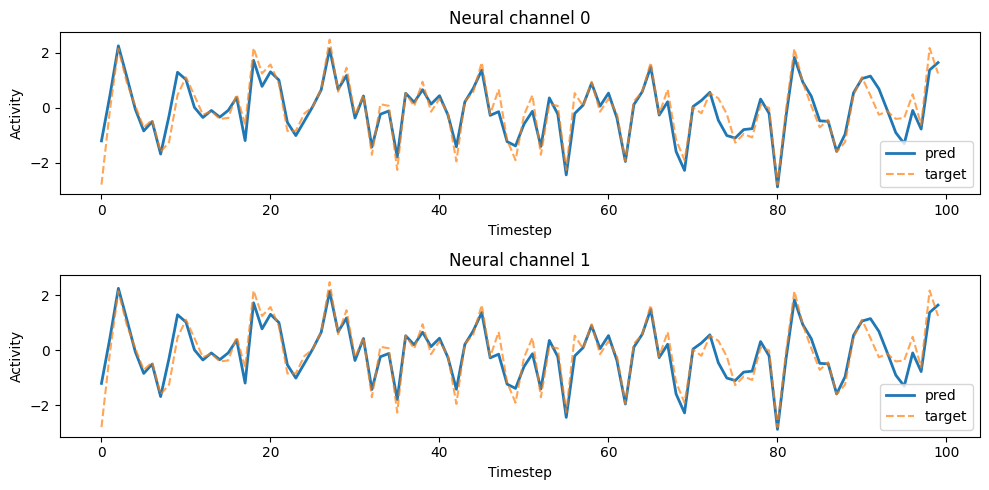

In [221]:
b = 0  # sample index
plt.figure(figsize=(10,5))
for c in range(neu_pred.shape[-1]):
    plt.subplot(n_neu,1,c+1)
    plt.plot(neu_pred[b,:,c].detach().cpu(), label='pred', lw=2)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()

## No seperation

In [222]:
# instantiate / train as usual
model = LagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    beh, neu = generate_batch(batch_size, T, tau)
    beh, neu = beh.to(device), neu.to(device)
    neu_query = torch.zeros_like(neu)  # decoder starts with zeros

    neu_pred, beh_pred, _, _ = model(beh, neu_query)
    #loss = loss_fn(torch.cat((neu_pred, beh_pred), dim=-1),
    #           torch.cat((neu, beh), dim=-1))    
    loss = loss_fn(neu_pred, neu)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

Step 500/2000, Loss: 0.077012
Step 1000/2000, Loss: 0.005279
Step 1500/2000, Loss: 0.004779
Step 2000/2000, Loss: 0.001379


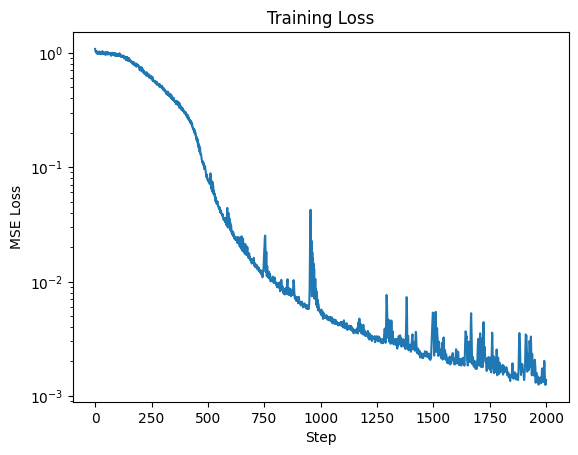

In [223]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [224]:
# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, z_out = model(beh_test, neu_query)

attn_weights.shape

torch.Size([1, 2, 100, 100])

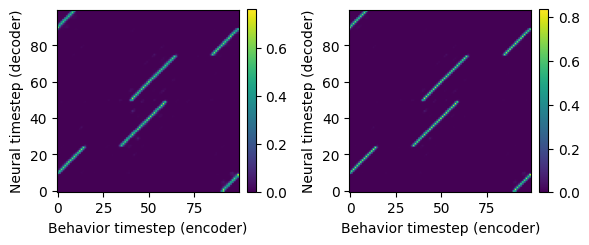

In [225]:
import math
import matplotlib.pyplot as plt

layer_attn = attn_weights[0]  # shape (n_heads, T_dec, T_enc)
n_heads = layer_attn.shape[0]
cols = math.ceil(math.sqrt(n_heads))
rows = math.ceil(n_heads / cols)

# Each subplot 3x3 inches → square layout
plt.figure(figsize=(3 * cols, 3 * rows))
for h in range(n_heads):
    attn_map = layer_attn[h].cpu().numpy()
    ax = plt.subplot(rows, cols, h + 1)
    im = ax.imshow(attn_map, aspect='equal', origin='lower', cmap='viridis')  # <- square cells
    ax.set_xlabel("Behavior timestep (encoder)")
    ax.set_ylabel("Neural timestep (decoder)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("heads_square.png", dpi=300, bbox_inches='tight')
plt.show()

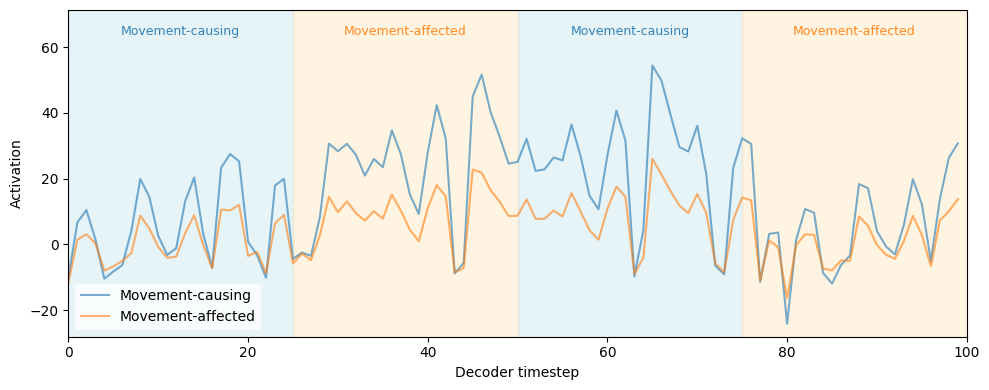

<Figure size 640x480 with 0 Axes>

In [226]:
import matplotlib.pyplot as plt
import torch

seg_len = 25  # match your generator

B, T, D2 = z_out.shape
D = D2 // 2
causal_out = z_out[0, :, :D].detach().cpu()
acausal_out = z_out[0, :, D:].detach().cpu()

fig, ax = plt.subplots(figsize=(10, 4))

# --- Shaded background for alternating causal/acausal periods ---
for s in range(0, T, seg_len):
    if (s // seg_len) % 2 == 0:
        ax.axvspan(s, s + seg_len, color='lightblue', alpha=0.3, zorder=0)
    else:
        ax.axvspan(s, s + seg_len, color='moccasin', alpha=0.4, zorder=0)

# --- Plot latent components ---
for d in range(D):
    ax.plot(causal_out[:, d], color='tab:blue', alpha=0.6,
            label='Movement-causing' if d == 0 else "")
for d in range(D):
    ax.plot(acausal_out[:, d], color='tab:orange', alpha=0.6,
            label='Movement-affected' if d == 0 else "")

# --- Labels, limits, etc. ---
ax.set_xlabel("Decoder timestep")
ax.set_ylabel("Activation")
ax.set_xlim(0, T)

# --- Add top text labels for shaded regions ---
ymin, ymax = ax.get_ylim()
label_y = ymax + (ymax - ymin) * 0.05  # place slightly above top of data

for s in range(0, T, seg_len):
    mid = s + seg_len / 2
    if (s // seg_len) % 2 == 0:
        ax.text(mid, label_y, "Movement-causing",
                color='tab:blue', ha='center', va='bottom', fontsize=9, alpha=0.9)
    else:
        ax.text(mid, label_y, "Movement-affected",
                color='tab:orange', ha='center', va='bottom', fontsize=9, alpha=0.9)

# Extend y-limits to make room for the top text
ax.set_ylim(ymin, label_y + (ymax - ymin) * 0.1)

# --- Move legend to bottom-left (away from text) ---
leg = ax.legend(loc='lower left', frameon=True, framealpha=0.8)
leg.get_frame().set_edgecolor('none')

plt.tight_layout()
plt.show()
plt.savefig("factors.png", dpi=300, bbox_inches='tight')

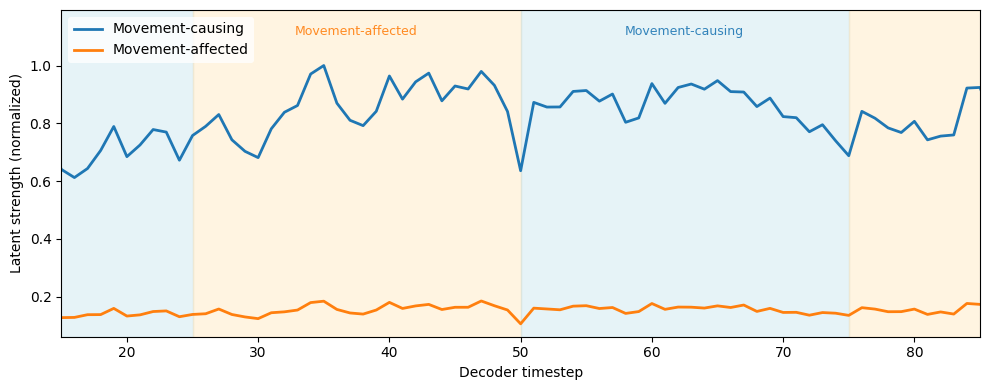

In [227]:
import matplotlib.pyplot as plt
import torch

# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(500, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, z_out = model(beh_test, neu_query)

# --- Compute mean of squares across batch (latent magnitude) ---
z_strength = (z_out ** 2).mean(dim=0).detach().cpu()  # [T, D_total]
T, D2 = z_strength.shape
D = D2 // 2

causal_out = z_strength[:, :D]
acausal_out = z_strength[:, D:]

# --- Average across latent dims to get envelope ---
causal_strength = causal_out.mean(dim=1)
acausal_strength = acausal_out.mean(dim=1)

# --- Normalize by global max across both ---
max_val = torch.max(torch.cat([causal_strength, acausal_strength]))
causal_strength /= max_val
acausal_strength /= max_val

# --- Plot ---
seg_len = 25  # match your generator
fig, ax = plt.subplots(figsize=(10, 4))

# Background shading for causal/acausal periods
for s in range(0, T, seg_len):
    if (s // seg_len) % 2 == 0:
        ax.axvspan(s, s + seg_len, color='lightblue', alpha=0.3, zorder=0)
    else:
        ax.axvspan(s, s + seg_len, color='moccasin', alpha=0.4, zorder=0)

# Plot normalized latent strength envelopes
ax.plot(causal_strength, color='tab:blue', lw=2, label='Movement-causing')
ax.plot(acausal_strength, color='tab:orange', lw=2, label='Movement-affected')

# Labels and limits
ax.set_xlabel("Decoder timestep")
ax.set_ylabel("Latent strength (normalized)")  # <- updated
ax.set_xlim(0, T)

# Optional figure title
#ax.set_title("Causal vs. acausal latent strength", fontsize=11)

# Add top text labels for shaded regions
ymin, ymax = ax.get_ylim()
label_y = ymax + (ymax - ymin) * 0.05

for i, s in enumerate(range(0, T, seg_len)):
    # Skip first and last boxes
    if i == 0 or i == (T // seg_len) - 1:
        continue

    mid = s + seg_len / 2
    if (s // seg_len) % 2 == 0:
        ax.text(mid, label_y, "Movement-causing",
                color='tab:blue', ha='center', va='bottom', fontsize=9, alpha=0.9)
    else:
        ax.text(mid, label_y, "Movement-affected",
                color='tab:orange', ha='center', va='bottom', fontsize=9, alpha=0.9)

ax.set_ylim(ymin, label_y + (ymax - ymin) * 0.1)

# Legend
leg = ax.legend(loc='upper left', frameon=True, framealpha=0.8)
leg.get_frame().set_edgecolor('none')
ax.set_xlim(15, 85)

plt.tight_layout()
plt.savefig("latent_strength.png", dpi=300, bbox_inches='tight')  # <- updated filename
plt.show()

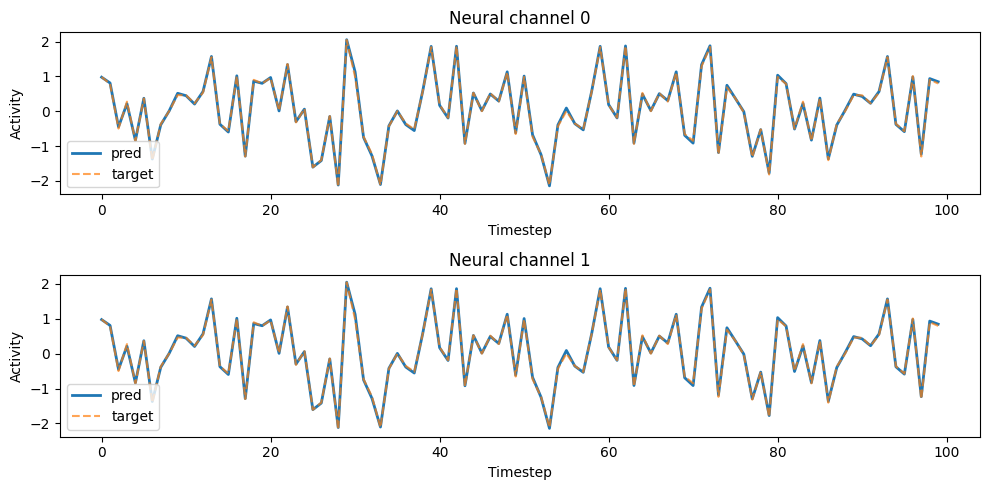

In [228]:
b = 0  # sample index
plt.figure(figsize=(10,5))
for c in range(neu_pred.shape[-1]):
    plt.subplot(2,1,c+1)
    plt.plot(neu_pred[b,:,c].detach().cpu(), label='pred', lw=2)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()